<h1 align="center"> Results </h1>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from config import path

In [2]:
import logging
from logs import turning_logger

turning_logger.setLevel(logging.INFO)

In [3]:
SPORTS = ("basketball", "handball", "soccer", "volleyball")

path.PLOT_PATH.mkdir(parents=True, exist_ok=True)

<h2> Dataset </h2>

In [4]:
from data_analysis.read_datasets import read_as_dicts

In [5]:
KEYS_TO_READ = [
    "matches",
    "var_stats",
    "tp",
    "permuted_tp",
    "optimal_tp",
    "diff_points_tp",
]

key_to_sport_to_data = read_as_dicts(SPORTS, KEYS_TO_READ)

In [6]:
from turning_point.match_coefficient import MatchTurningPoint

key_to_sport_to_data["mtp"] = {
    sport: MatchTurningPoint.from_matches_and_turning_point(
        key_to_sport_to_data["matches"][sport],
        key_to_sport_to_data["tp"][sport]
    )
    for sport in SPORTS
}

In [7]:
import warnings
from turning_point.permutation_coefficient import TurningPointComparison

PERCENTILES = [2.5, 25, 50, 75, 97.5]

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    key_to_sport_to_data["comparison_tp"] = {
        sport: TurningPointComparison(
            key_to_sport_to_data["tp"][sport], 
            key_to_sport_to_data["permuted_tp"][sport],
            key_to_sport_to_data["optimal_tp"][sport],
        ).comparison(PERCENTILES)
        for sport in SPORTS
    }

<h2> Style </h2>

In [8]:
import data_analysis.plots.utils.customization
from data_analysis.plots.utils.plot_functions import flatten_axes

In [9]:
from data_analysis.plots.variances_temporal_progression import plot_variances_temporal_progression
from data_analysis.plots.turning_point_boxplot import plot_boxplot_turning_points
from data_analysis.plots.comparison_boxplot import plot_comparison_boxplot
from data_analysis.plots.new_pontuation import plot_new_pontuation_system
from data_analysis.plots.comparison_scatter import plot_comparison_scatter

<h2> Temporal Progression </h2>

In [10]:
TOURNEY_NAMES_AND_IDS = (
    ("NBA (Basketball - 2019/2020)", "nba@/basketball/usa/nba-2019-2020/"),
    ("Superleague - RU (Volleyball - 2019/2020)", "superleague@/volleyball/russia/superleague-2019-2020/"),
    ("La Liga (Soccer - 2019/2020)", "laliga@/soccer/spain/laliga-2019-2020/"),
    ("Bundesliga (Handball - 2019/2020)", "bundesliga@/handball/germany/bundesliga-2019-2020/"),
)
LAST_DATE = 60

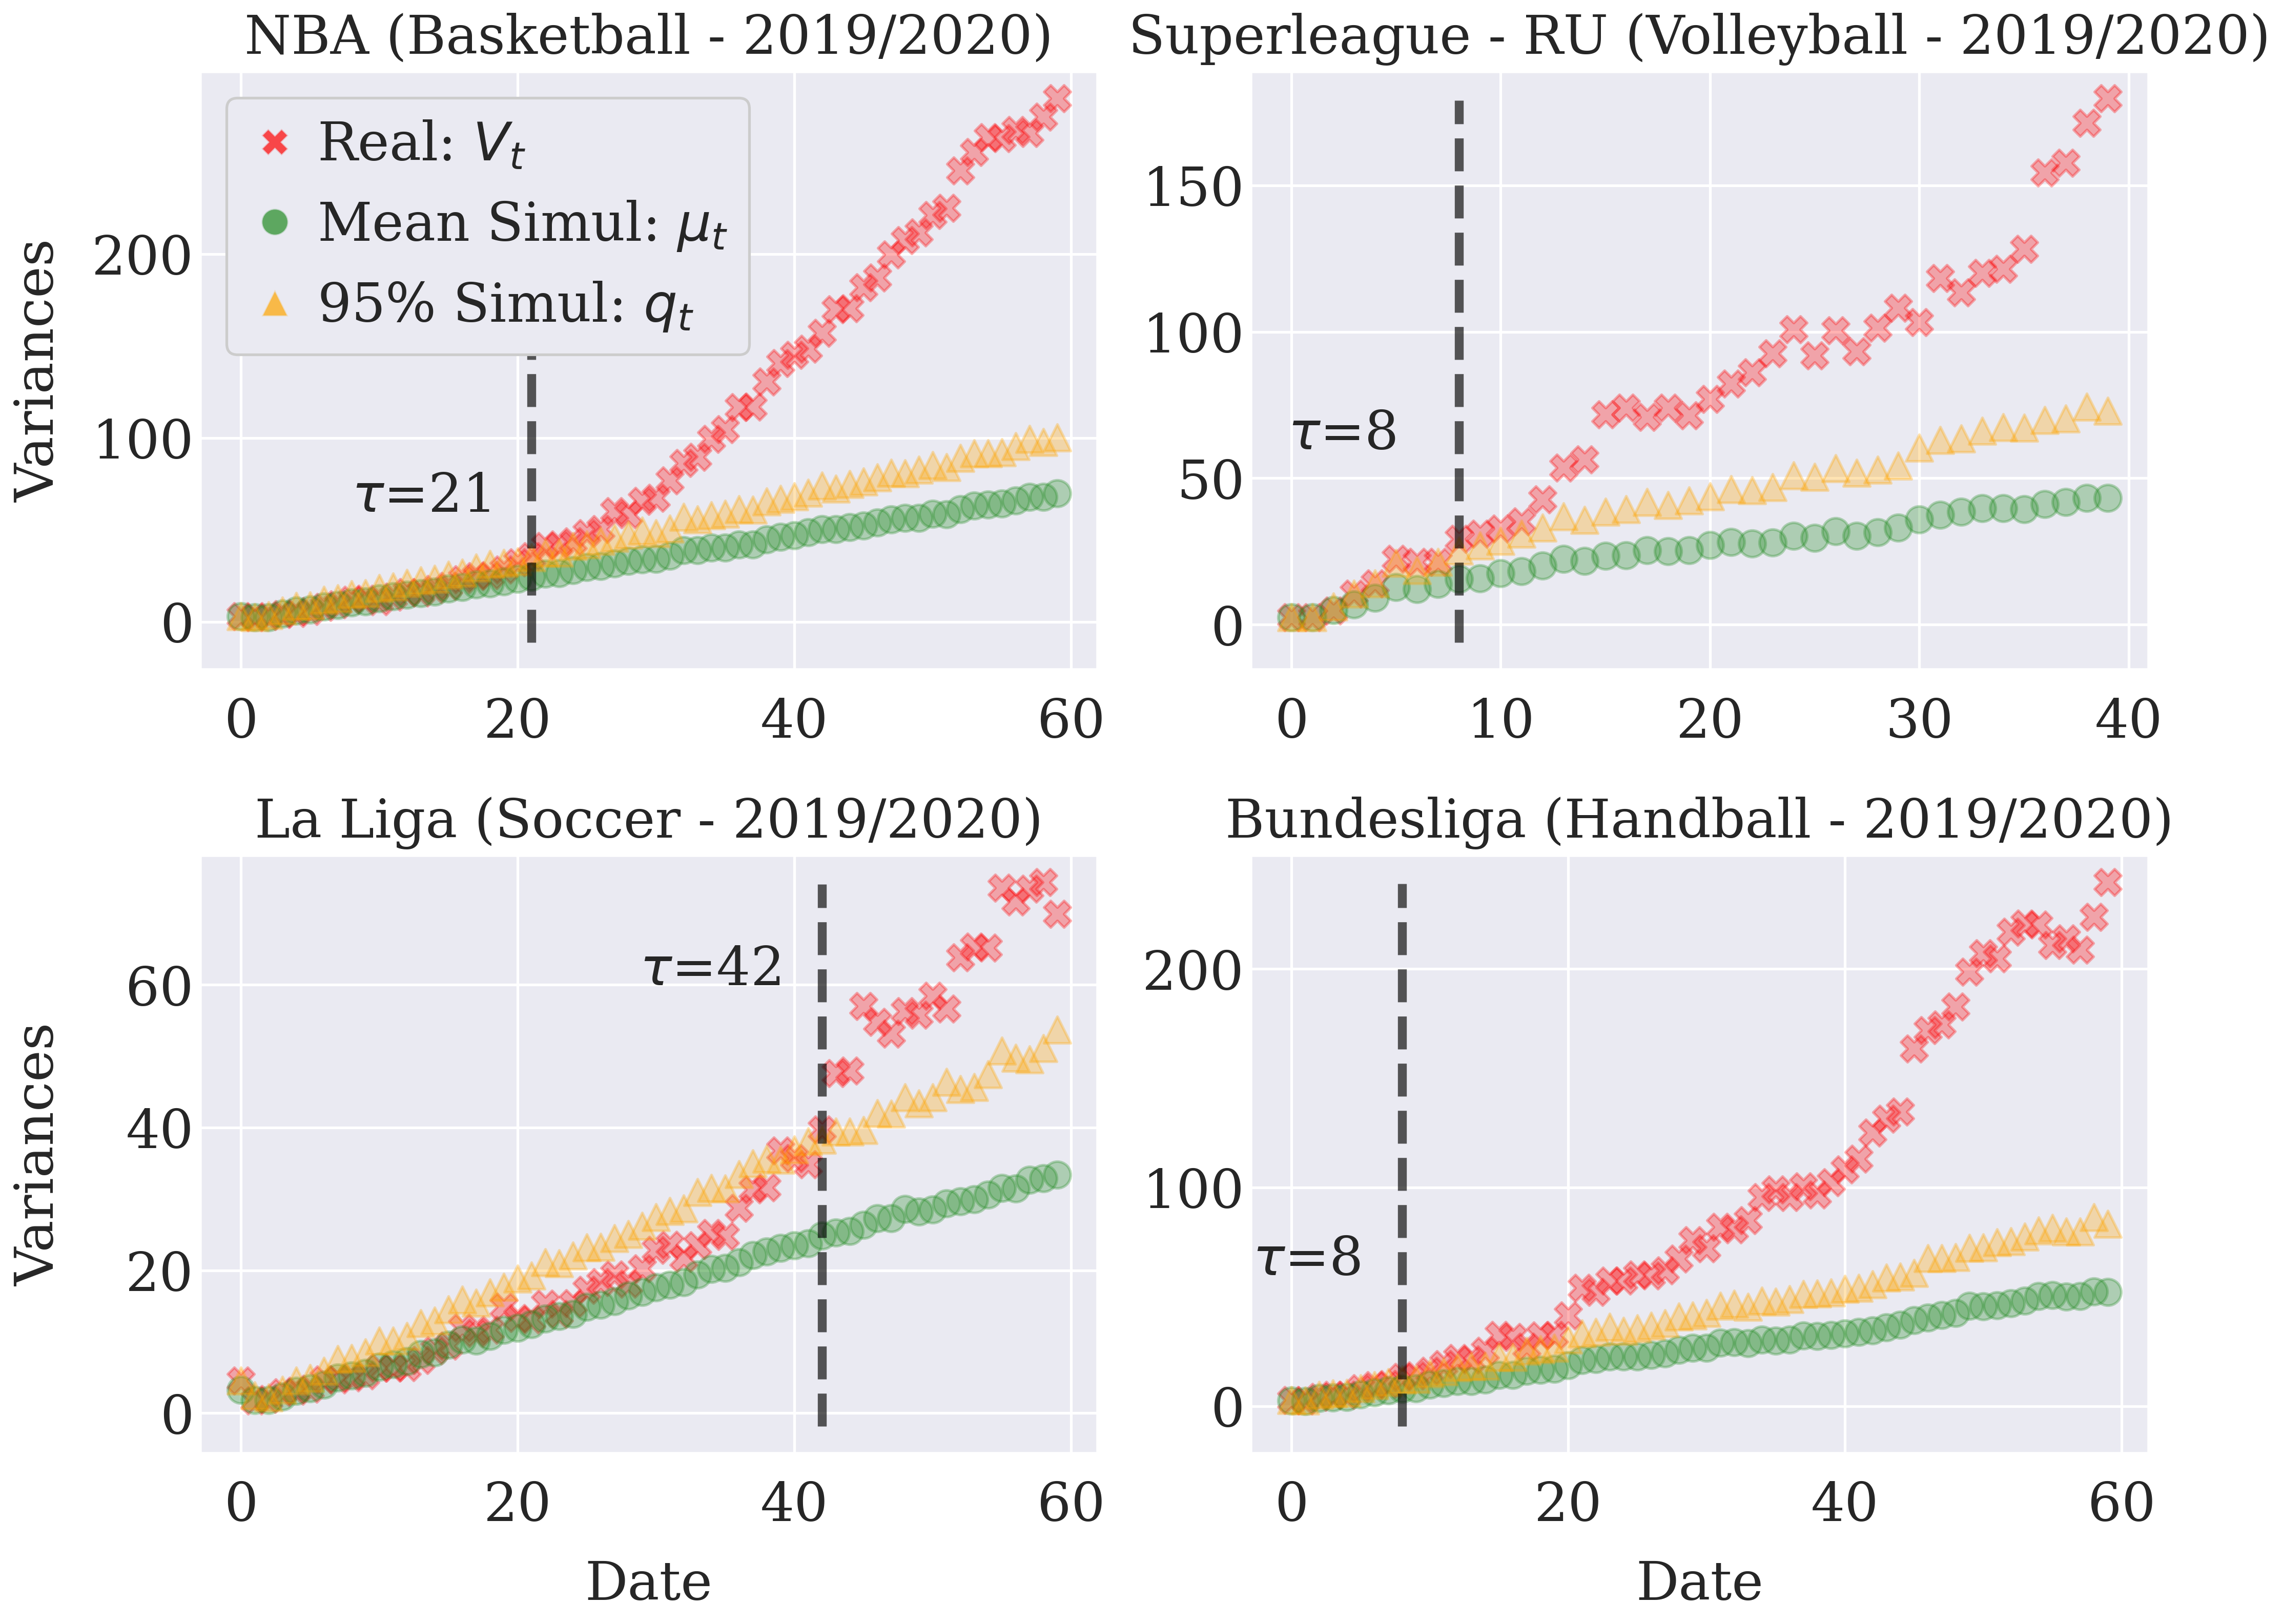

In [11]:
fig, axs = plt.subplots(2, 2, figsize=(18, 13))

plot_variances_temporal_progression(
    fig, axs,
    key_to_sport_to_data["tp"],
    key_to_sport_to_data["var_stats"],
    TOURNEY_NAMES_AND_IDS,
    LAST_DATE,
)
for ax in flatten_axes(axs):
    ax.set_title(ax.get_title(), fontsize=30)

plt.savefig(path.PLOT_PATH / "turning_point_progression.pdf")

<h2> Turning Point </h2>

<h3> All tournaments </h3>

In [12]:
MTP_TP_COLUMNS = {
    "match turning point": "Matches",
    "%turning point": "%Date"
}

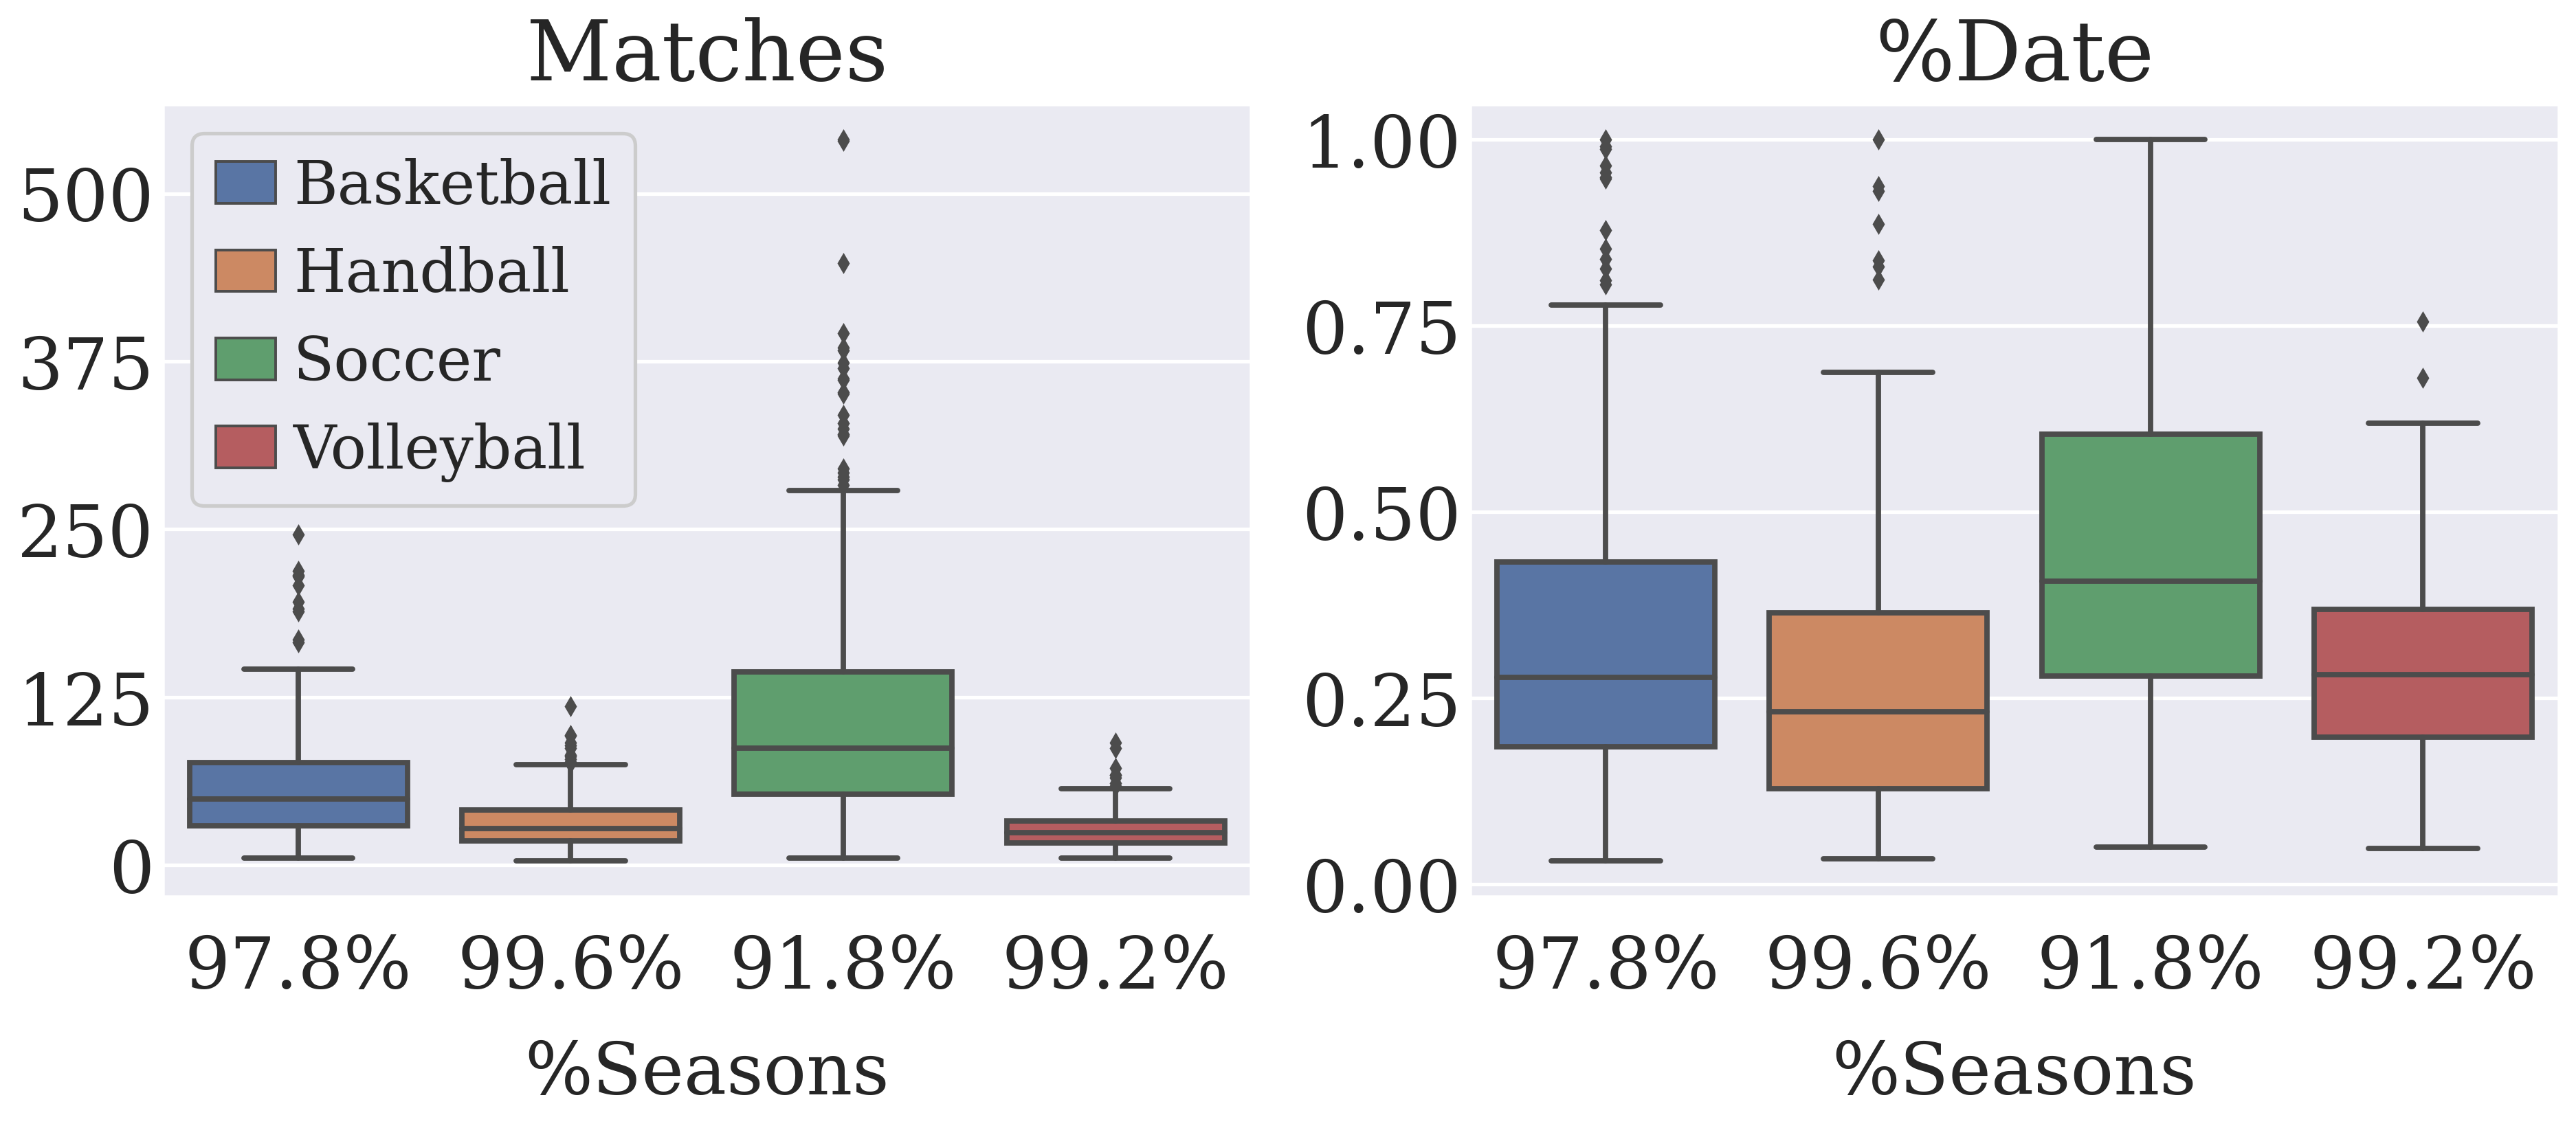

In [13]:
fig, axs = plt.subplots(ncols=2, figsize=(18, 6))

plot_boxplot_turning_points(
    axs,
    key_to_sport_to_data["tp"],
    key_to_sport_to_data["mtp"],
    MTP_TP_COLUMNS,
)

axs[0].set_yticks([0, 125, 250, 375, 500])

plt.savefig(path.PLOT_PATH / "turning_point_all_tournaments_boxplot.pdf")

<h3> Division </h3>

In [14]:
from data_analysis.division import Division

div_data = Division(pd.read_csv(path.DATA_PATH / "divisions.csv"))
div_data.df.value_counts(["sport", "division"]).sort_index()

sport       division
basketball  1           35
handball    1           30
soccer      1           62
            2           15
            3            3
volleyball  1           29
            2            1
Name: count, dtype: int64

In [15]:
SPORT = "soccer"
tp_df = key_to_sport_to_data["tp"][SPORT].df

div_df = pd.concat(
    {div: tp_df.loc[div_data.filter_division_in_index(tp_df, div)] for div in [1, 2]},
    axis="columns"
)

In [16]:
HUE_COLUMNS = {
    (1, "%turning point"): "First Division",
    (2, "%turning point"): "Second Division",
}

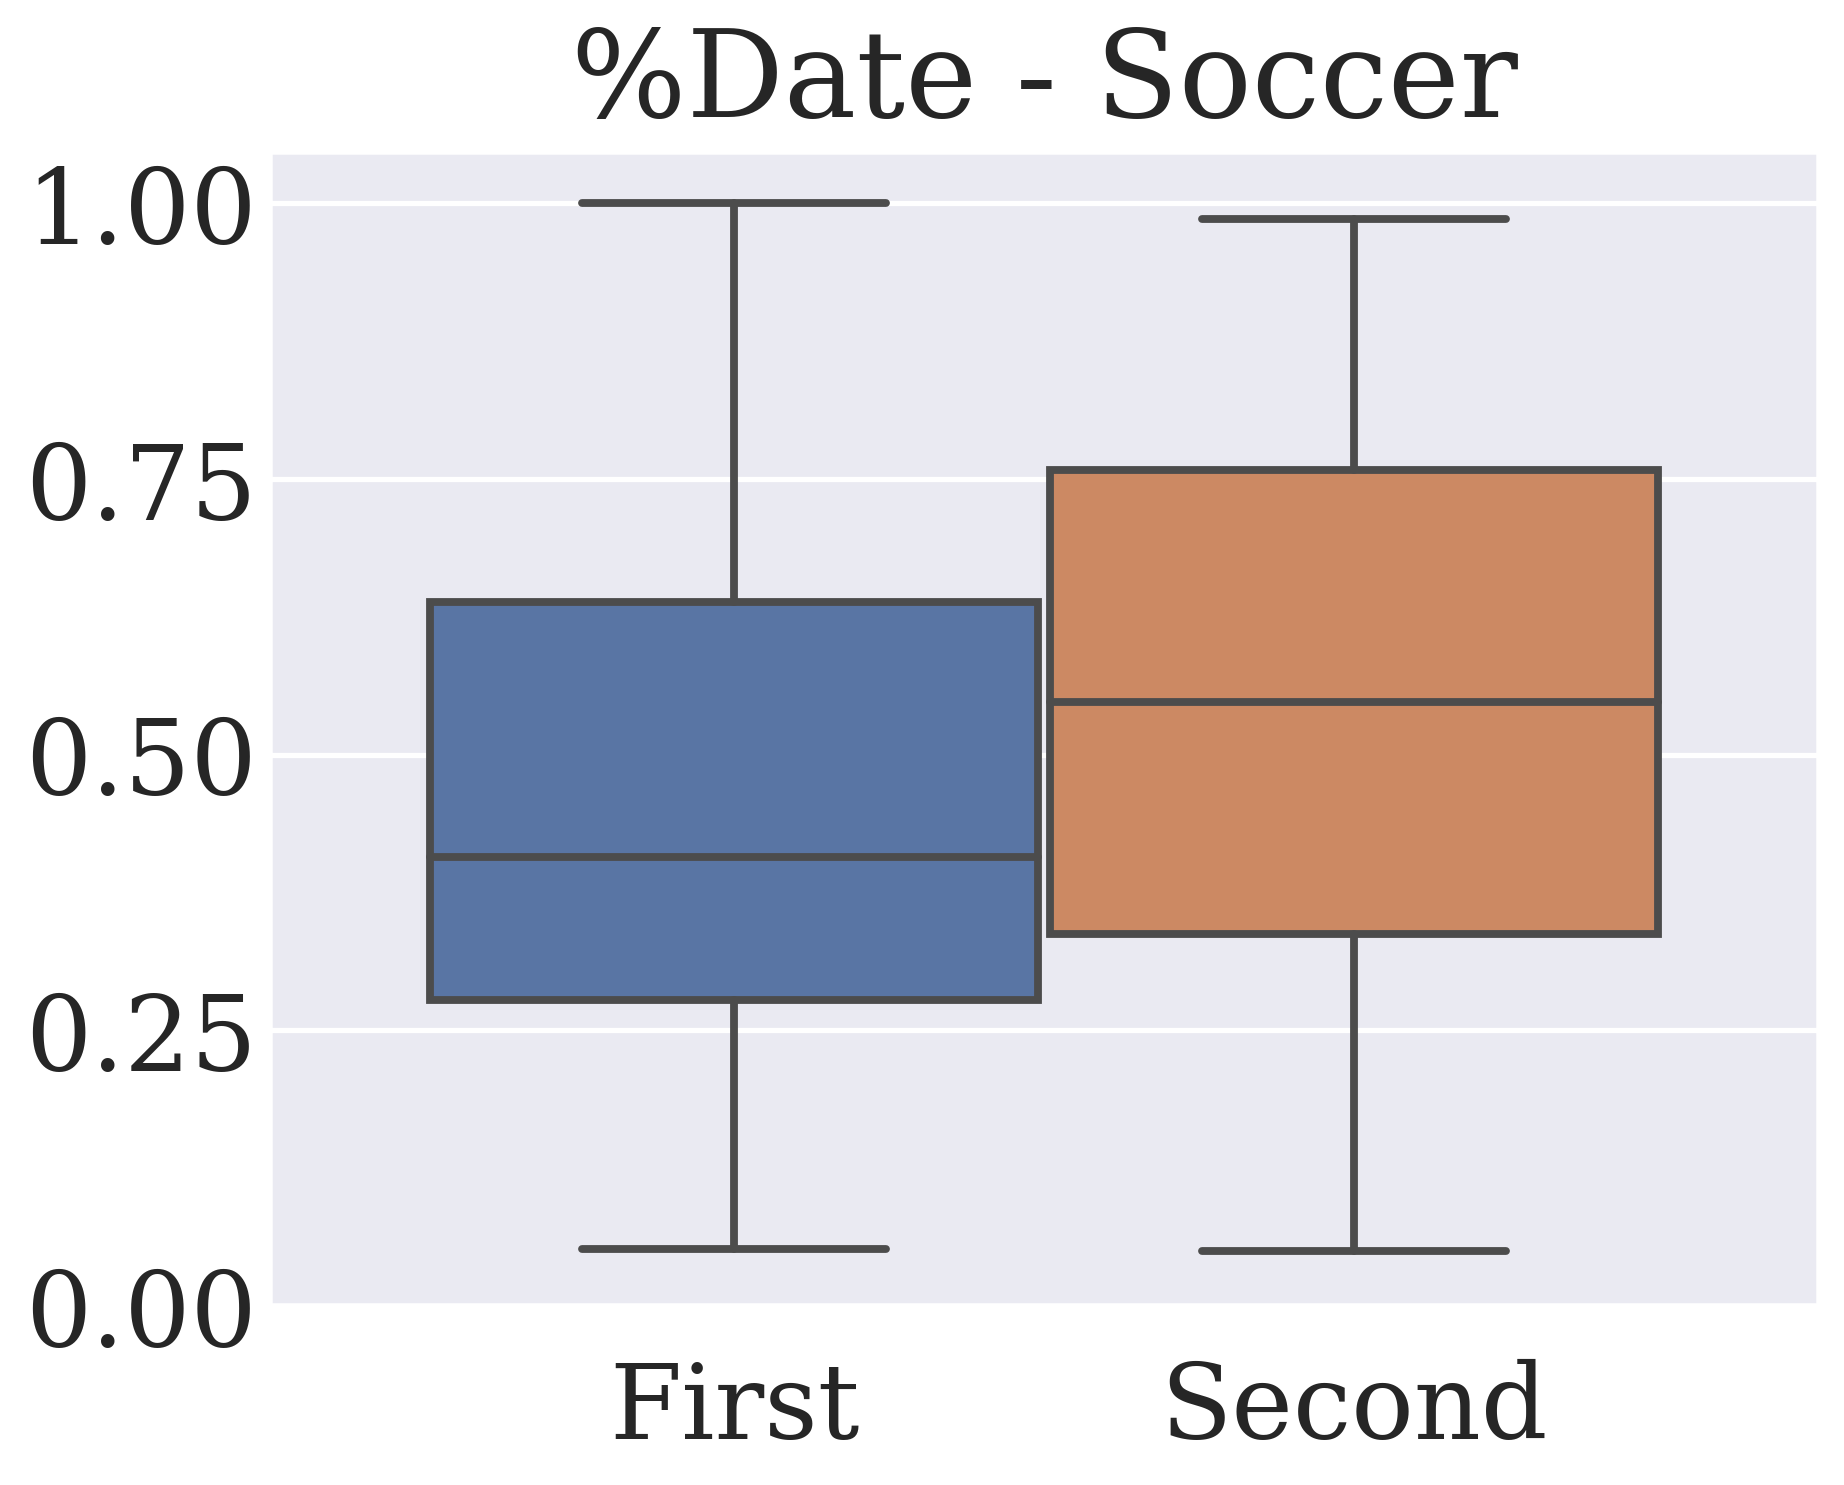

In [17]:
_, ax = plt.subplots(figsize=(8, 6))
plot_comparison_boxplot(ax, {"soccer": div_df}, hue_columns=HUE_COLUMNS, legend=False)

ax.set_title("%Date - Soccer")
ax.set_yticks([0, 0.25, 0.5, 0.75, 1.0])
ax.set_xticks([-0.20, 0.20], ["First", "Second"])

plt.savefig(path.PLOT_PATH / "division_comparison_boxplot.pdf")

<h3> Other Pontuation System </h3>

In [18]:
other_pontuation = {
    "volleyball": pd.concat(
            {
            "normal": key_to_sport_to_data["tp"]["volleyball"].df,
            "new": key_to_sport_to_data["diff_points_tp"]["volleyball"].df,
        }, axis="columns"
    )
}

In [19]:
TP_COLUMNS = {
    ("normal", "%turning point"): "3:2 - (3, 0)",
    ("new", "%turning point"): "3:2 - (2, 1)",
}

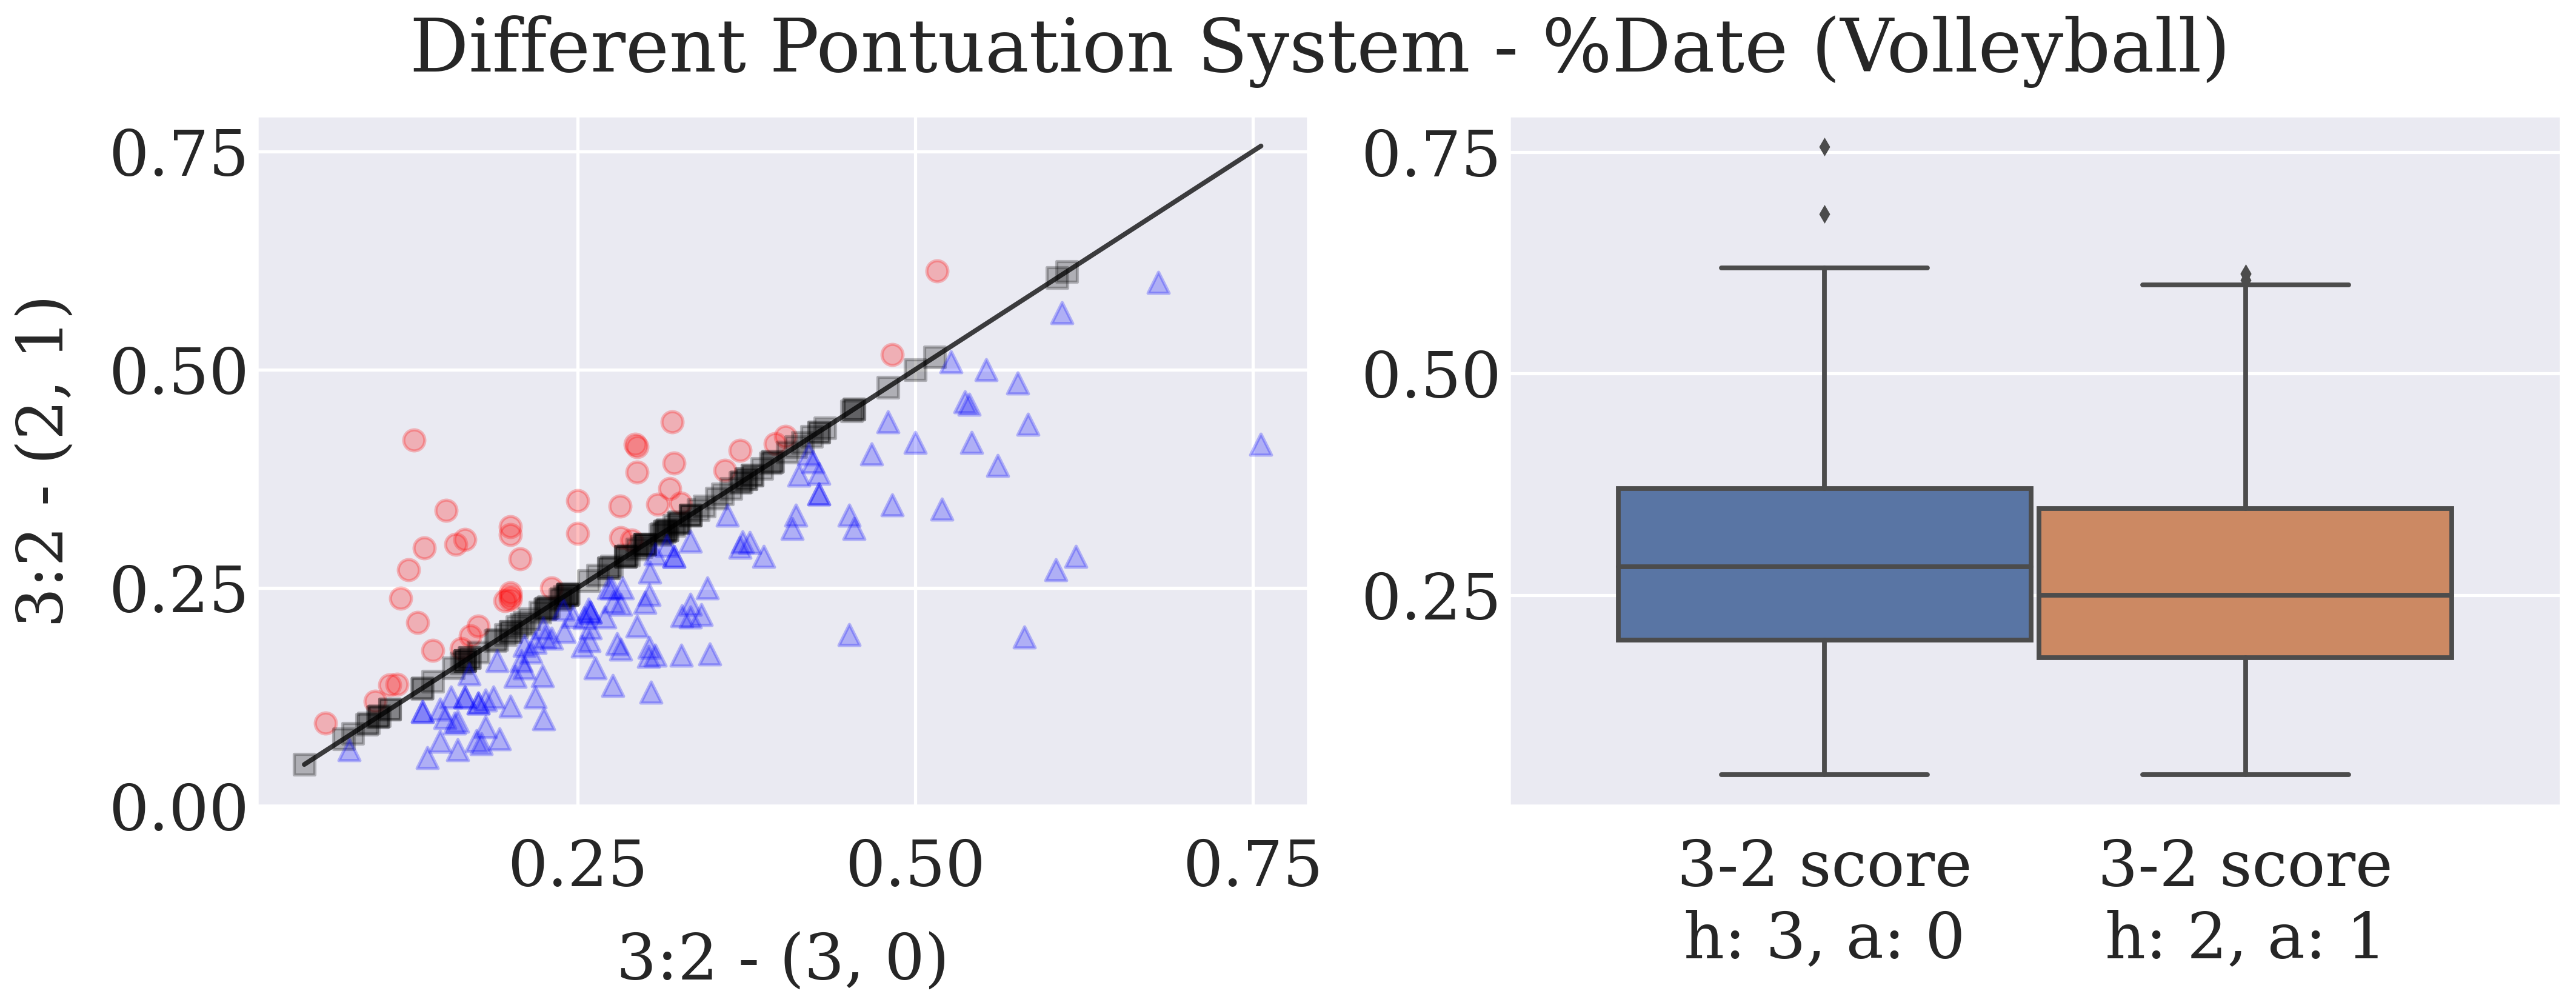

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(18, 6))

plot_new_pontuation_system(fig, axs, other_pontuation, tp_columns=TP_COLUMNS, no_difference_margin=0.01)
fig.suptitle("Different Pontuation System - %Date (Volleyball)", size=35)

plt.savefig(path.PLOT_PATH / "new_pontuation_system.pdf")

<h2> Permuted Turning Point </h2>

<h3> All tournaments </h3>

In [21]:
HUE_COLUMNS = {
    ("%turning point", "normal"): "Real",
    ("%turning point", "mean"): "Permuted",
}

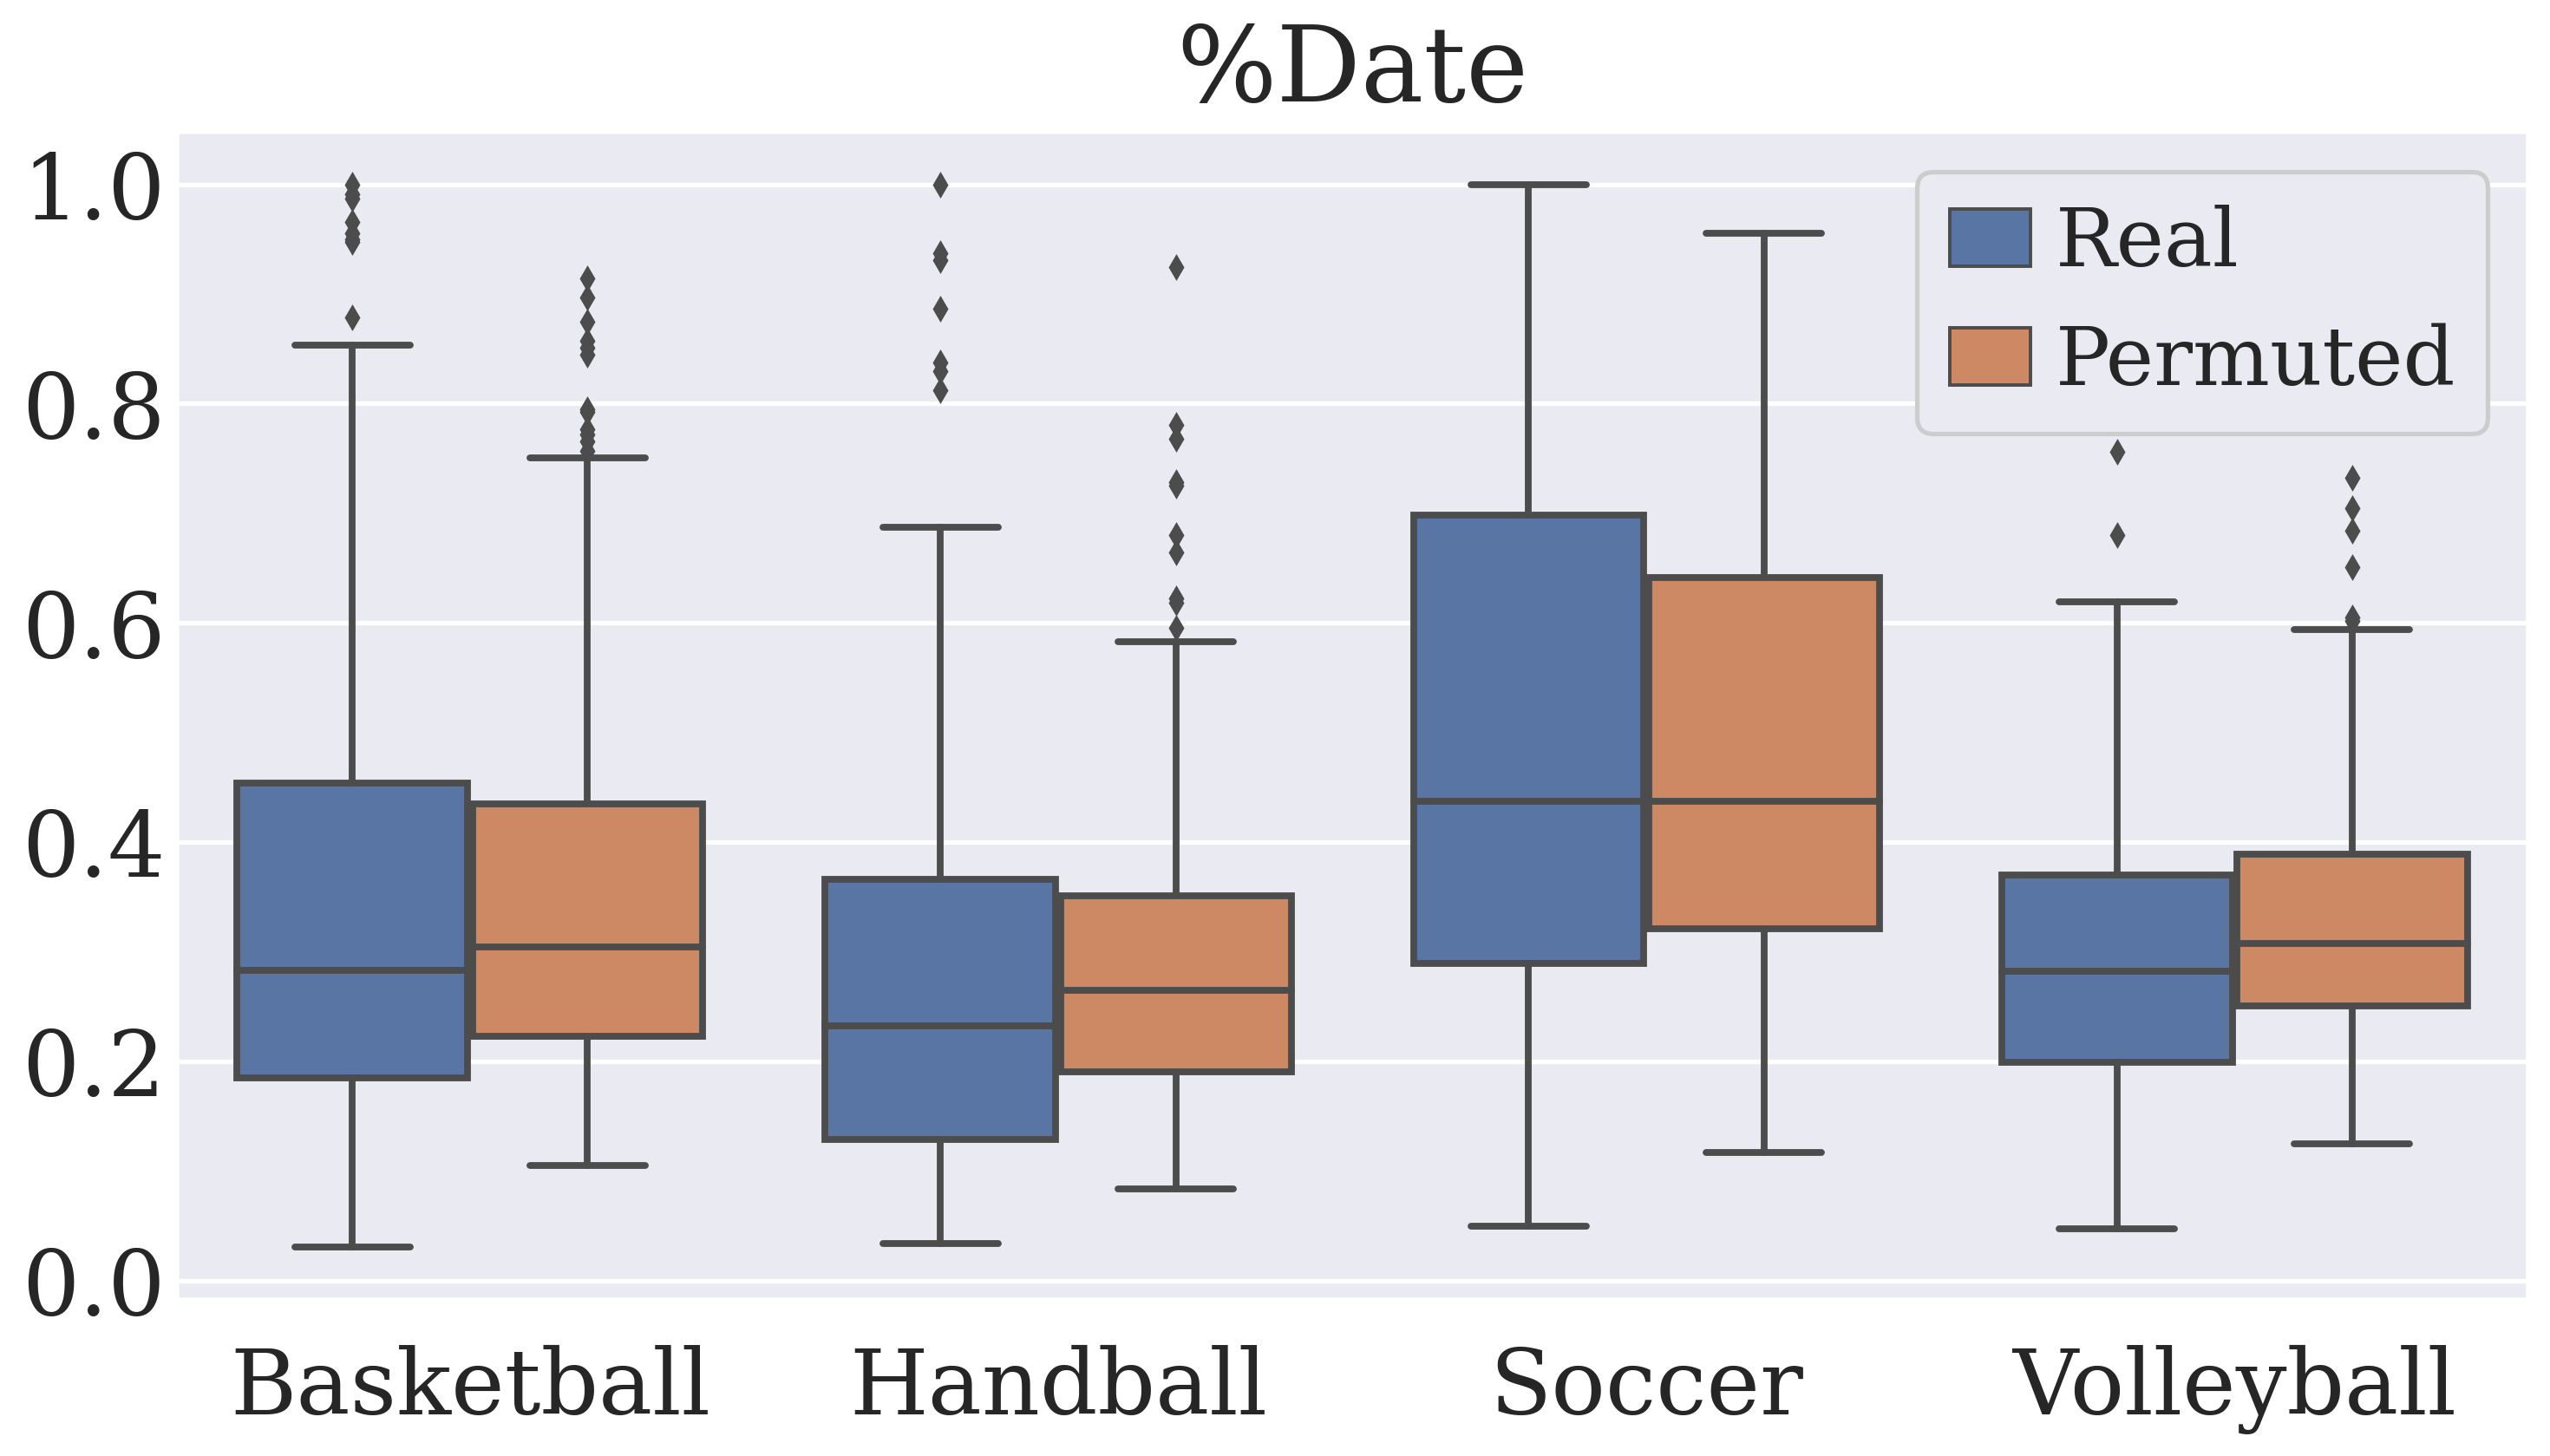

In [22]:
_, ax = plt.subplots(figsize=(14, 7))
plot_comparison_boxplot(
    ax,
    key_to_sport_to_data["comparison_tp"],
    x_column="sport",
    hue_columns=HUE_COLUMNS
)

ax.set_title("%Date")
ax.legend(fontsize=27)

plt.savefig(path.PLOT_PATH / "normal_permuted_comparison_boxplot.pdf")

<h3> Scatter Comparison </h3>

In [23]:
TP_COLUMNS = {
    ("%turning point", "normal"): "Real",
    ("%turning point", "mean"): "Permuted",
}

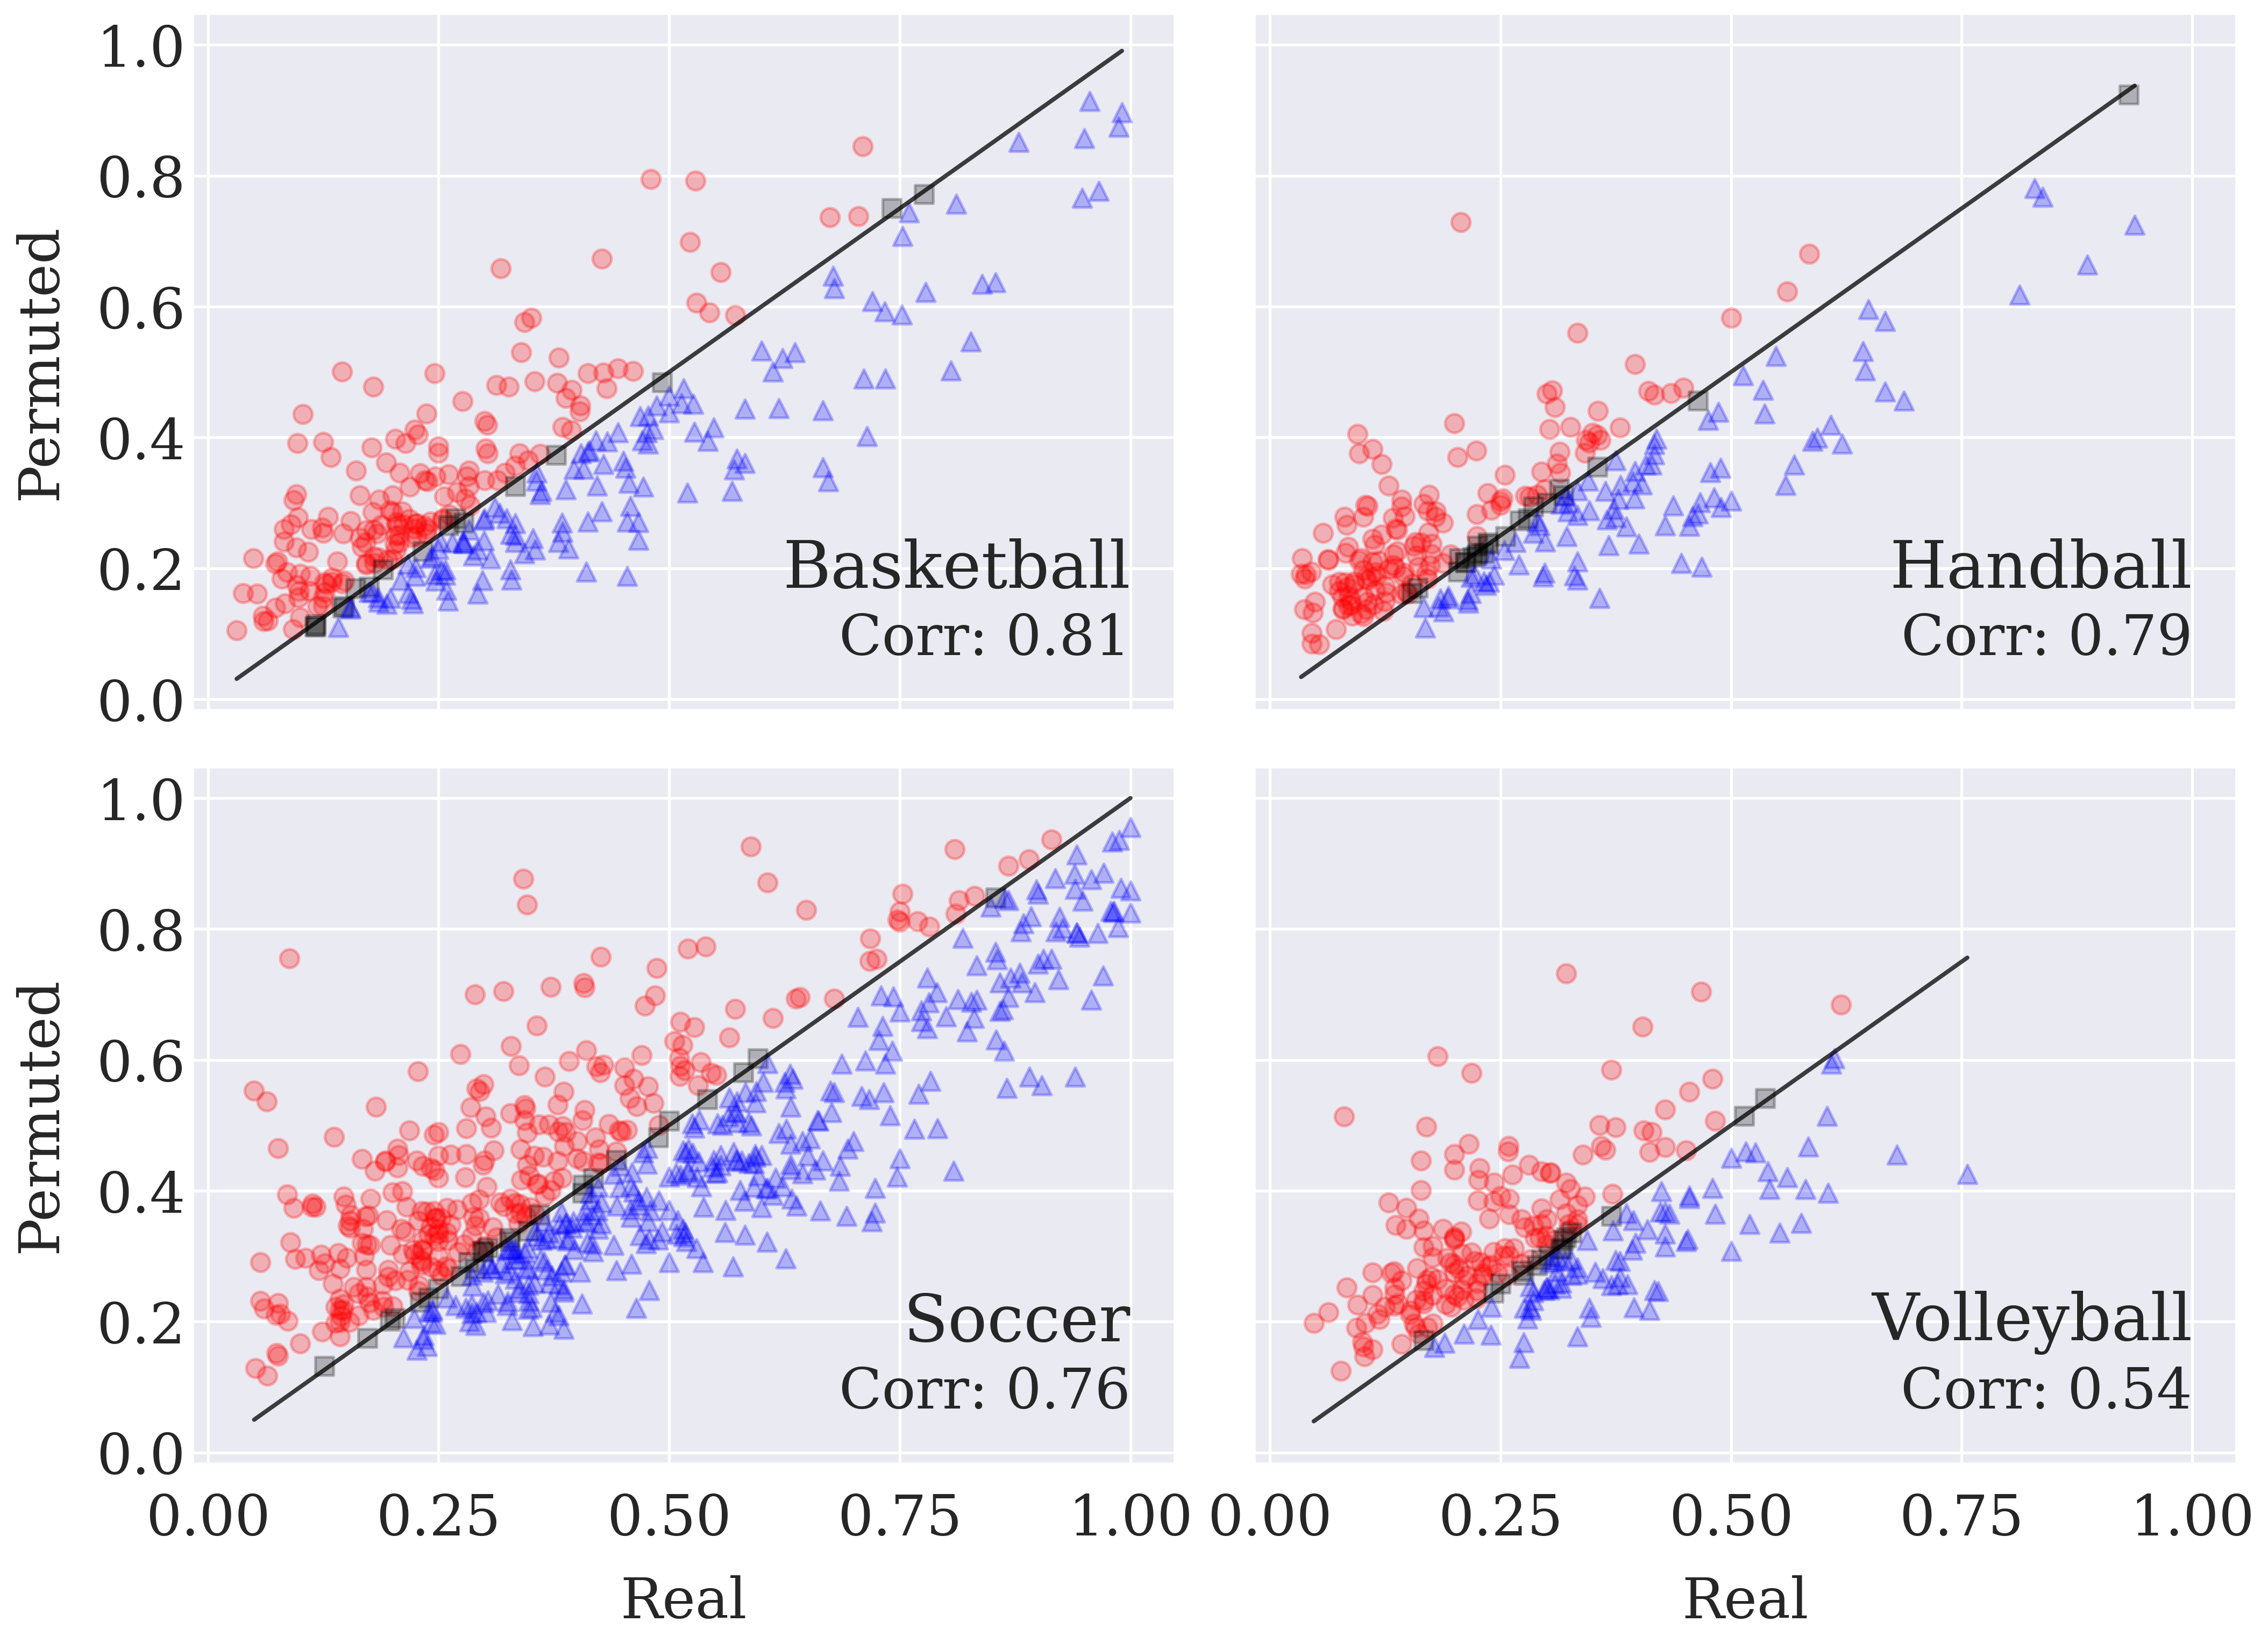

In [24]:
fig, axs = plt.subplots(2, 2, figsize=(18, 13), sharex="all", sharey="all")

plot_comparison_scatter(
    fig, axs,
    key_to_sport_to_data["comparison_tp"],
    TP_COLUMNS,
    no_difference_margin=0.01,
)
fig.subplots_adjust(wspace=0.08, hspace=0.08)

plt.savefig(path.PLOT_PATH / "turning_point_permuted_comparison_scatter.pdf")

<h2> Optimal Turning Point </h2>

<h3> Oracle </h3>

In [25]:
from data_analysis.plots.comparison_scatter import plot_comparison_scatter

TP_COLUMNS = {
    ("%turning point", "normal"): "Real",
    ("%turning point", "tp_maximizer-current"): "Oracle Maximizer",
}

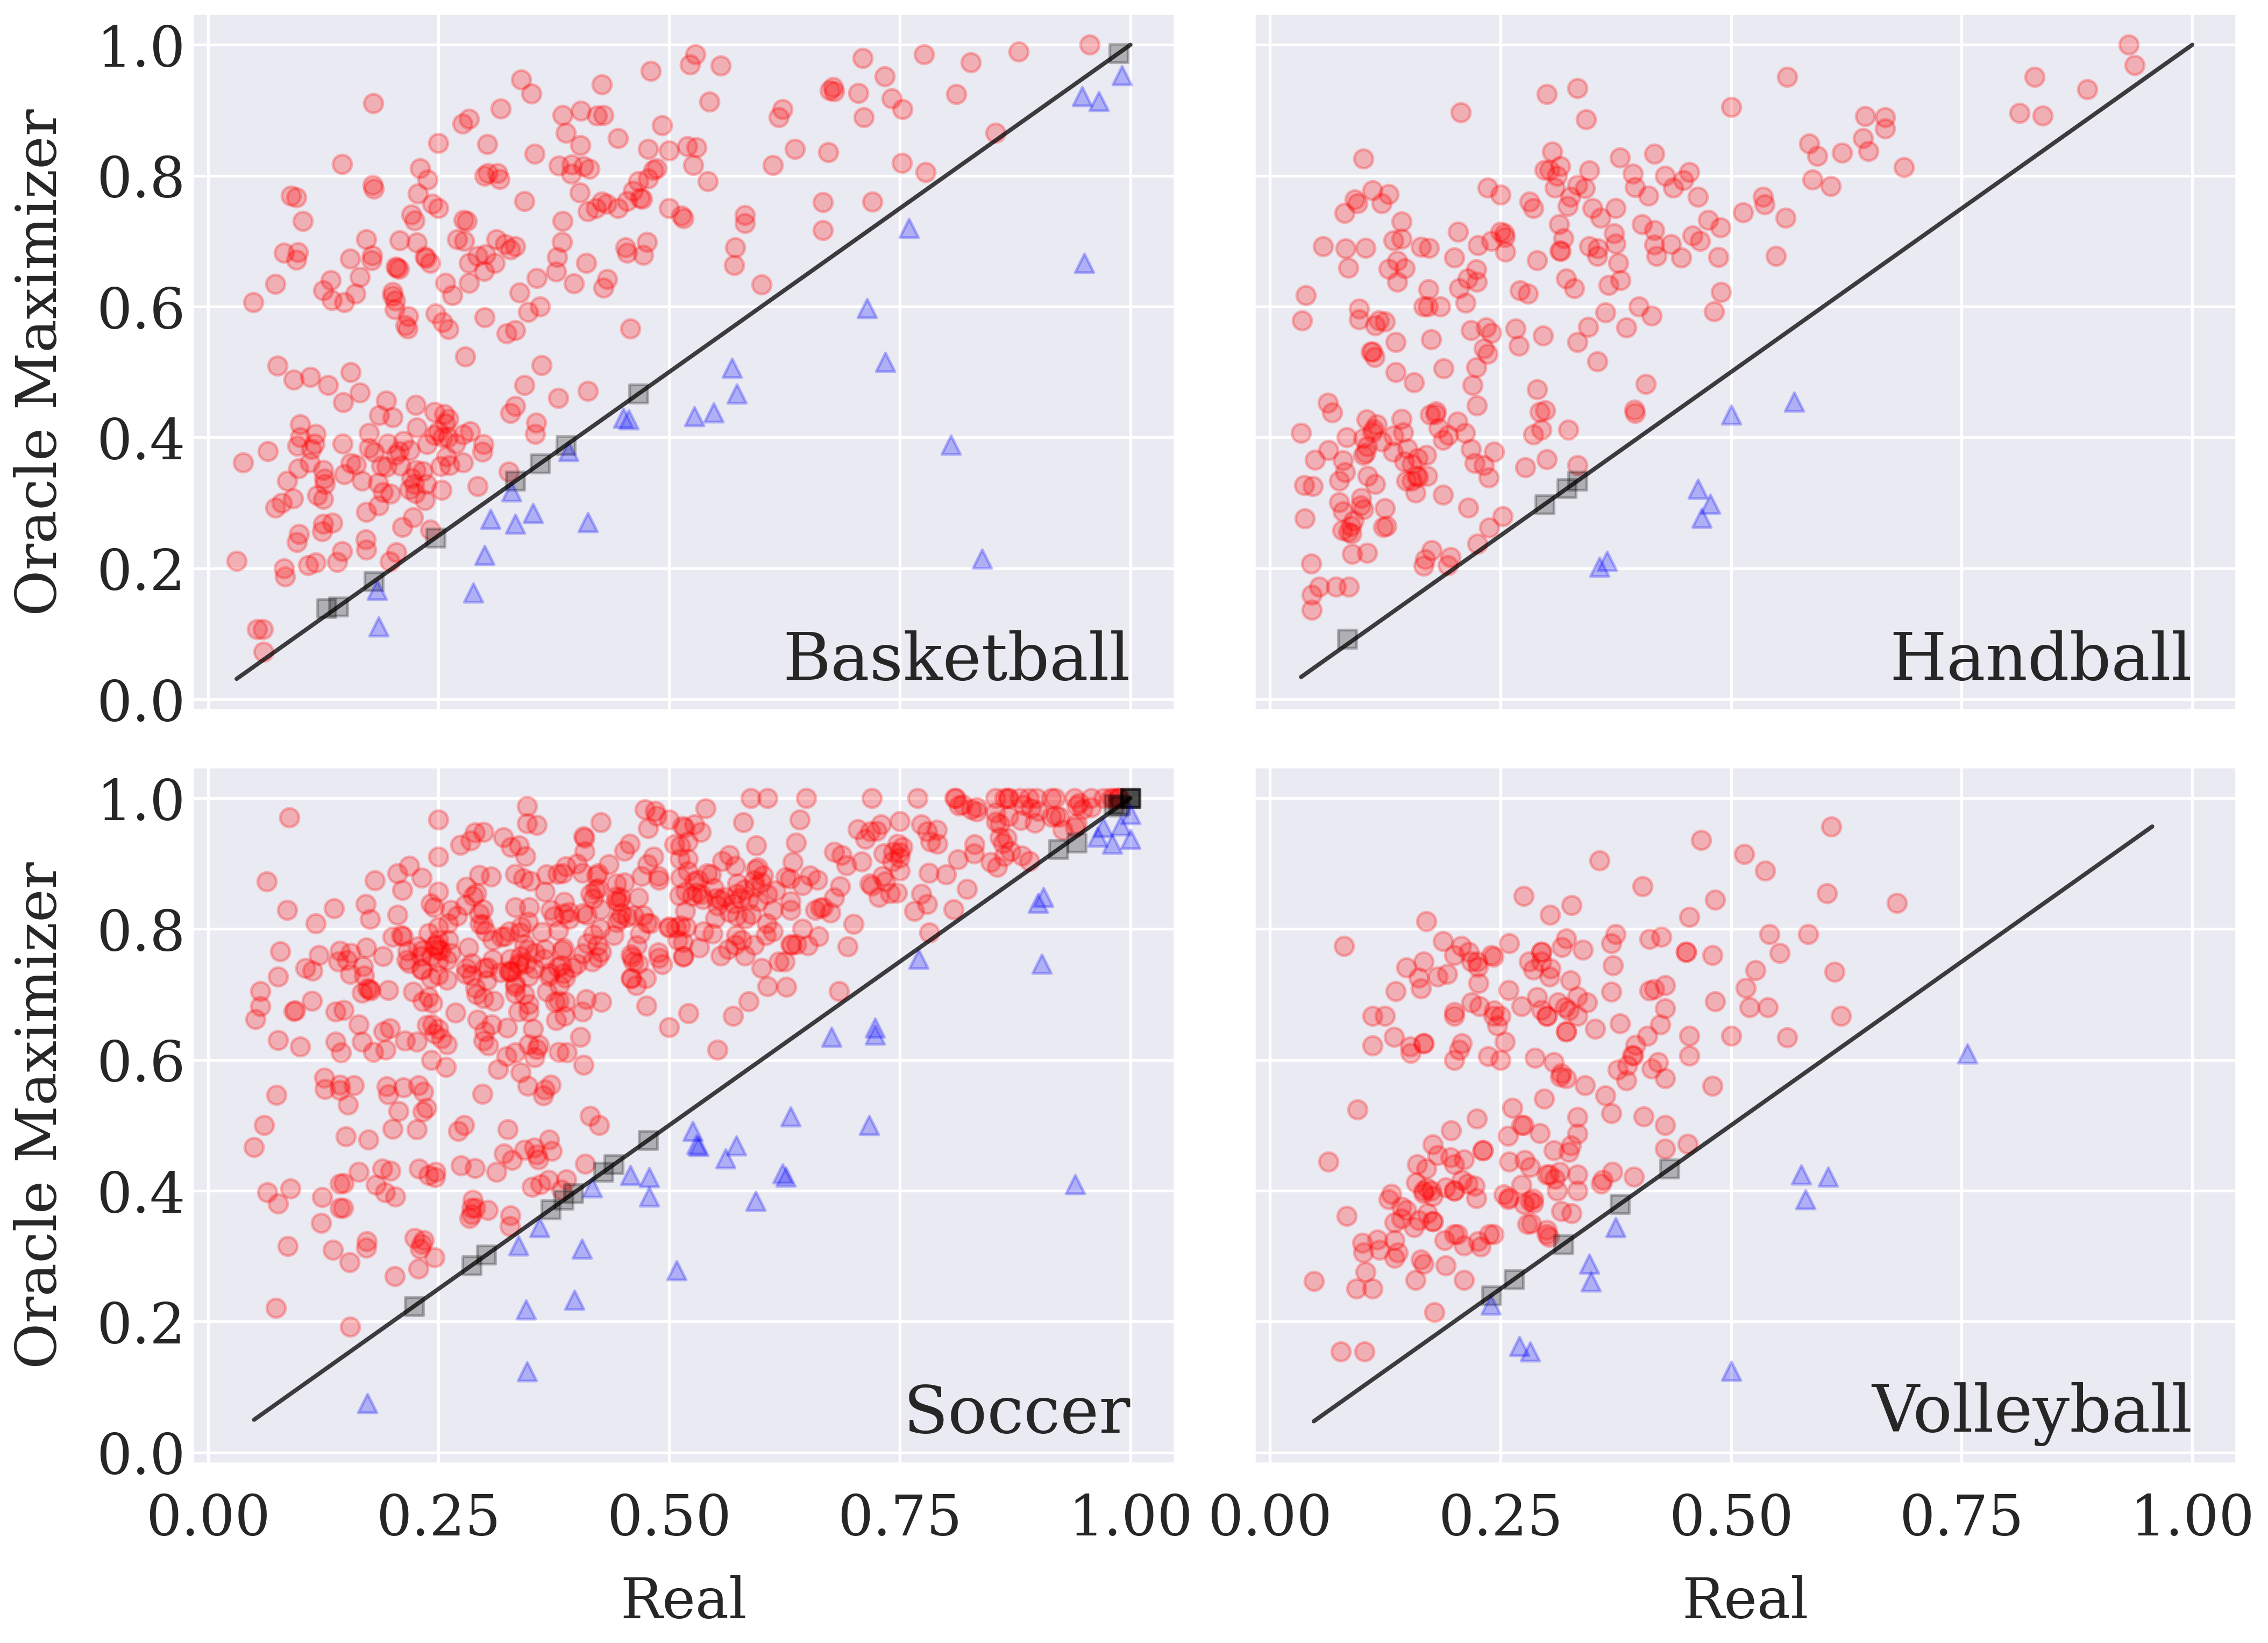

In [26]:
fig, axs = plt.subplots(2, 2, figsize=(18, 13), sharex="all", sharey="all")

plot_comparison_scatter(
    fig, axs,
    key_to_sport_to_data["comparison_tp"],
    TP_COLUMNS,
    pearson_corr_kwargs=None,
    title_as_text_kwargs={"y": 0.01},
    no_difference_margin=0.01,
)
fig.subplots_adjust(wspace=0.08, hspace=0.08)

plt.savefig(path.PLOT_PATH / "turning_point_oracle_maximizer_comparison_scatter.pdf")

<h3> Yesterday Model </h3>

In [27]:
from data_analysis.plots.comparison_scatter import plot_comparison_scatter

TP_COLUMNS = {
    ("%turning point", "normal"): "Real",
    ("%turning point", "tp_maximizer-previous"): "Yesterday Maximizer",
}

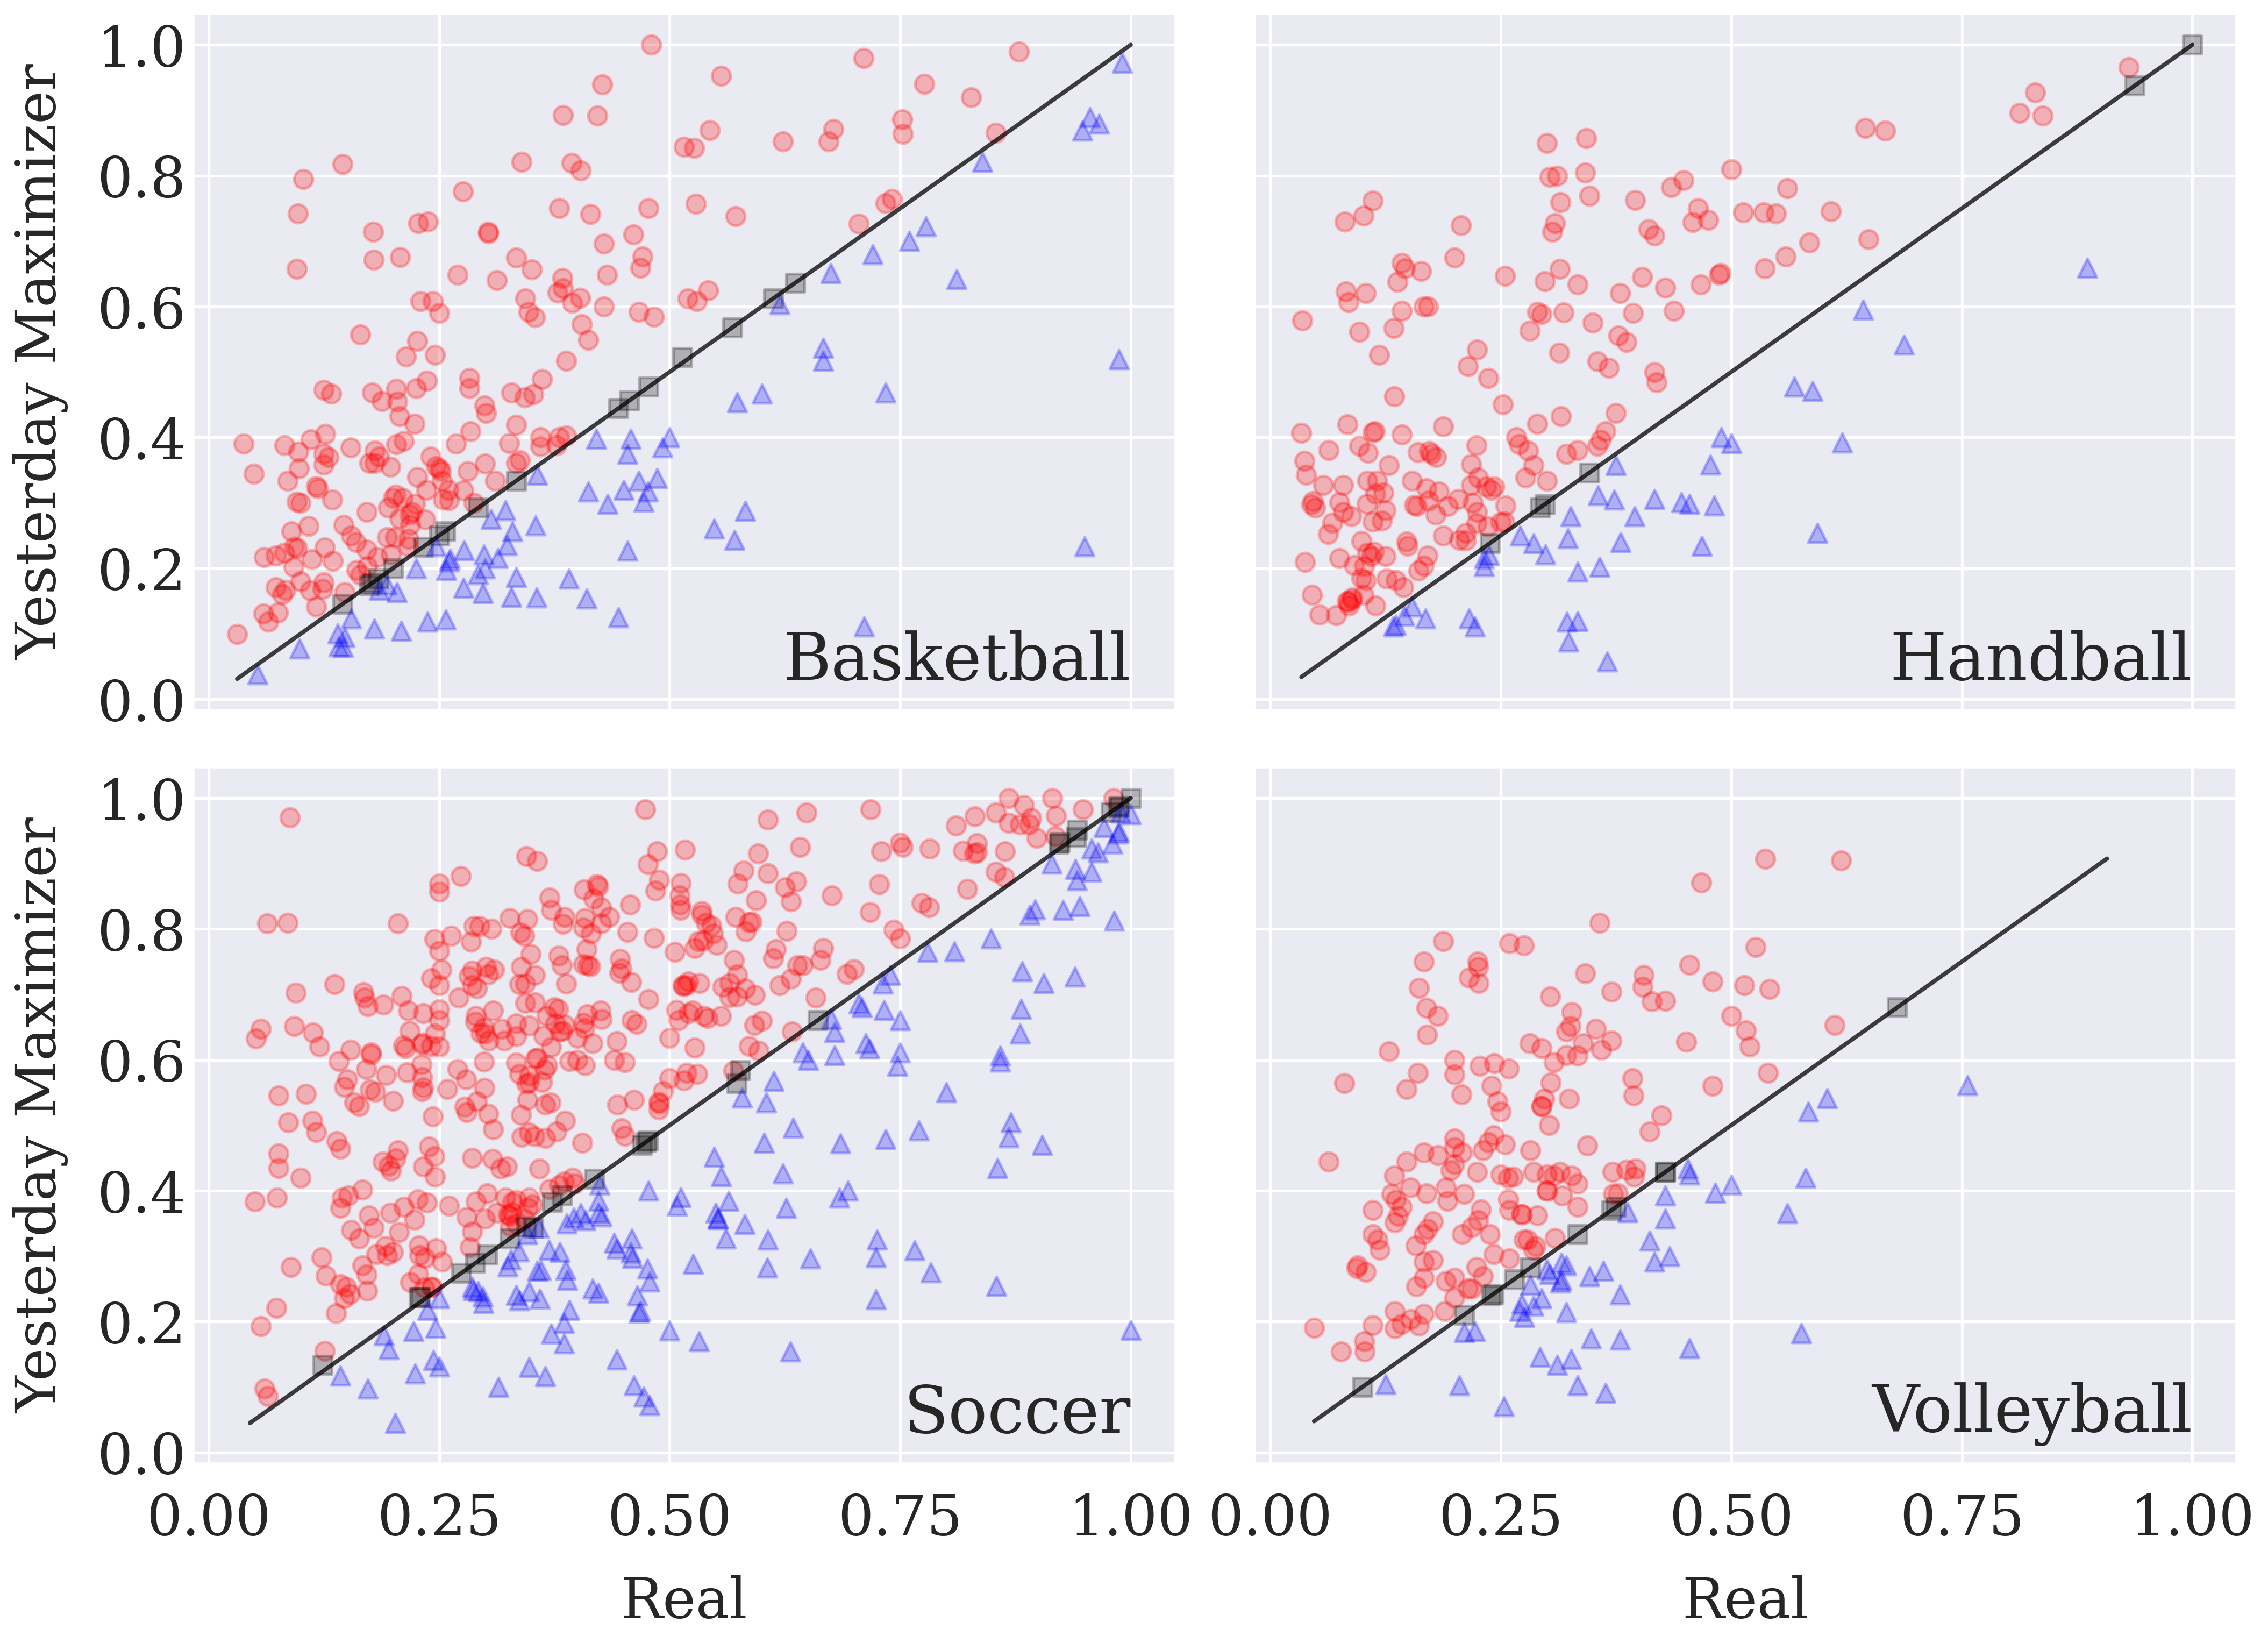

In [28]:
fig, axs = plt.subplots(2, 2, figsize=(18, 13), sharex="all", sharey="all")

plot_comparison_scatter(
    fig, axs,
    key_to_sport_to_data["comparison_tp"],
    TP_COLUMNS,
    pearson_corr_kwargs=None,
    title_as_text_kwargs={"y": 0.01},
    no_difference_margin=0.01,
)
fig.subplots_adjust(wspace=0.08, hspace=0.08)

plt.savefig(path.PLOT_PATH / "turning_point_yesterday_maximizer_comparison_scatter.pdf")

<h2> Comparison Turning Point </h2>

<h3> Optimal Turning Point </h3>

In [29]:
from data_analysis.numeric_analysis import get_optimal_comparison

TP_TYPE = "%turning point"
OPTIMAL_COLUMNS = [
    "tp_minimizer-current",
    "tp_minimizer-previous",
    "tp_maximizer-current",
    "tp_maximizer-previous"
]

optimal_comp = get_optimal_comparison(
    key_to_sport_to_data["comparison_tp"],
    OPTIMAL_COLUMNS, 
    TP_TYPE
)
optimal_comp

< 2.5%    < real    > real   > 97.5%
optimal col           sport                                             
tp_minimizer-current  basketball  0.577640  0.829193  0.130435  0.000000
                      handball    0.577947  0.870722  0.076046  0.003802
                      soccer      0.598854  0.826648  0.081662  0.001433
                      volleyball  0.582031  0.863281  0.093750  0.003906
tp_minimizer-previous basketball  0.254658  0.580745  0.248447  0.018634
                      handball    0.349810  0.650190  0.159696  0.003802
                      soccer      0.216332  0.571633  0.227794  0.012894
                      volleyball  0.300781  0.605469  0.203125  0.011719
tp_maximizer-current  basketball  0.003106  0.077640  0.875776  0.599379
                      handball    0.000000  0.026616  0.958175  0.737643
                      soccer      0.002865  0.055874  0.842407  0.621777
                      volleyball  0.003906  0.042969  0.929688  0.585938
tp_maximizer-previous basketball  0.018634  0.226708  0.593168  0.214286
                      handball    0.007605  0.159696  0.703422  0.365019
                      soccer      0.014327  0.214900  0.581662  0.250716
                      volleyball  0.027344  0.175781  0.652344  0.234375

<h3> No Turning Points </h3>

In [30]:
from data_analysis.numeric_analysis import get_no_tp

DESIRED_COLUMNS = [("%turning point", "mean"), ("%turning point", "normal")] 

no_tp = get_no_tp(key_to_sport_to_data["comparison_tp"], DESIRED_COLUMNS)
no_tp.groupby("sport").size()

sport
basketball     8
handball       2
soccer        66
volleyball     2
dtype: int64